# <center>Practice 07. Classification Heart Disease Demo</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.spatial import distance

## Чтение данных

In [3]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Возьмём данные заболеваний сердца у пациентов, которые можно скачать [тут](https://www.kaggle.com/code/ahmedadell30/heart-disease-prediction-with-ann-models/data).

Описание датасета: <br>

* age - age in years <br>
* sex - (1 = male; 0 = female) <br>
* cp - chest pain type <br>
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) <br>
* chol - serum cholestoral in mg/dl <br>
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
* restecg - resting electrocardiographic results <br>
* thalach - maximum heart rate achieved <br>
* exang - exercise induced angina (1 = yes; 0 = no) <br>
* oldpeak - ST depression induced by exercise relative to rest <br>
* slope - the slope of the peak exercise ST segment <br>
* ca - number of major vessels (0-3) colored by flourosopy <br>
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect <br>
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак **target** имеет ли пациент заболевание сердца.

## EDA

In [4]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

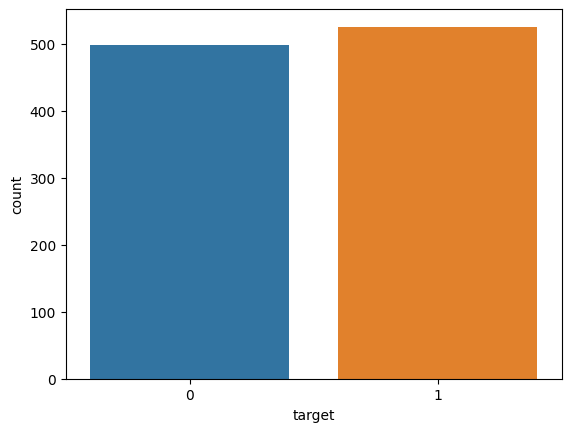

In [5]:
sns.countplot(x="target", data=df)
plt.show()

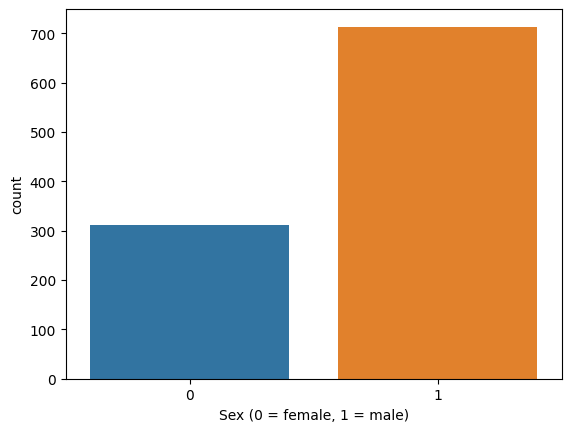

In [6]:
sns.countplot(x='sex', data=df)
plt.xlabel("Sex (0 = female, 1 = male)")
plt.show()

In [7]:
df.groupby('target').mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,56.569138,0.827655,0.482966,134.106212,251.292585,0.164329,0.456914,139.130261,0.549098,1.600200,1.166333,1.158317,2.539078
1,52.408745,0.570342,1.378327,129.245247,240.979087,0.134981,0.598859,158.585551,0.134981,0.569962,1.593156,0.370722,2.119772


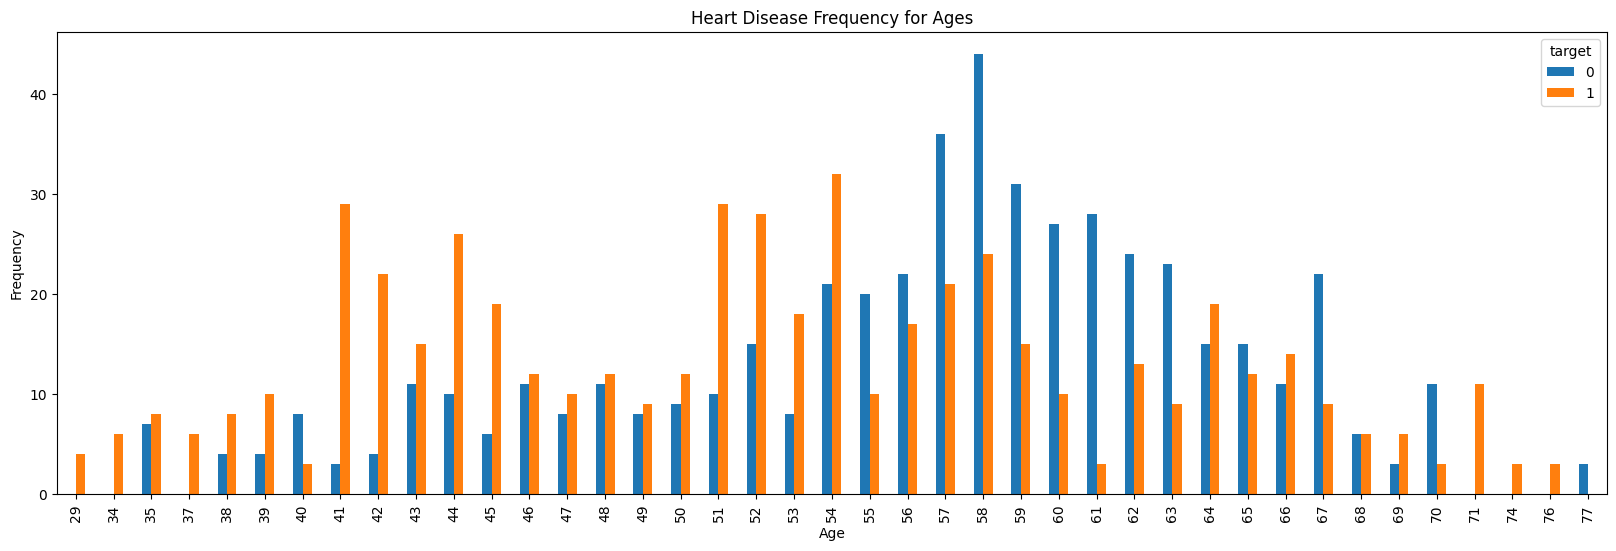

In [8]:
pd.crosstab(df.age,df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

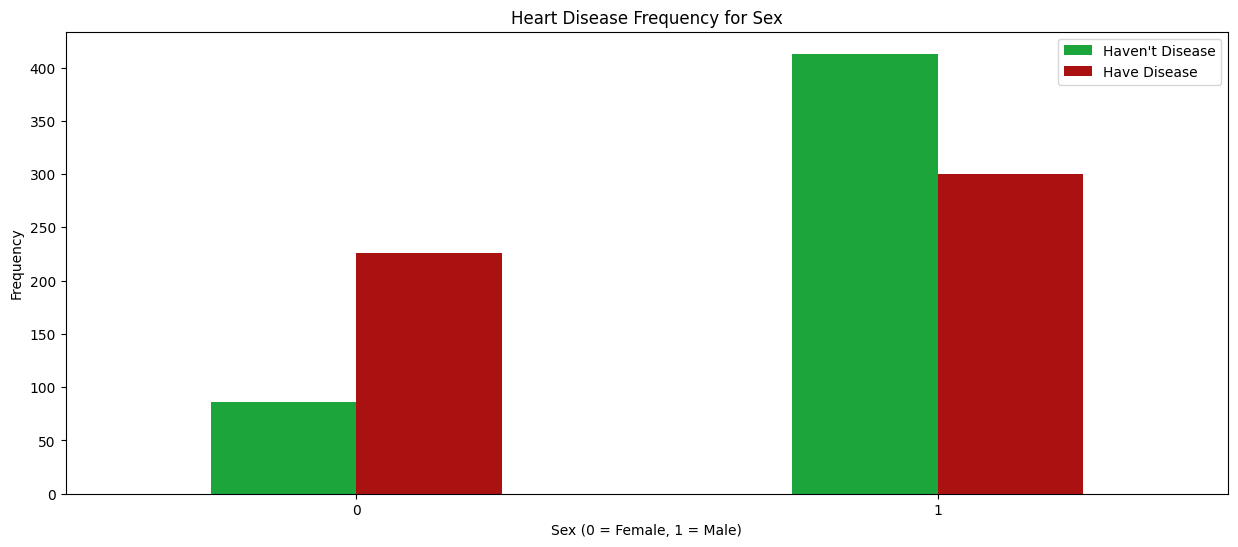

In [9]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

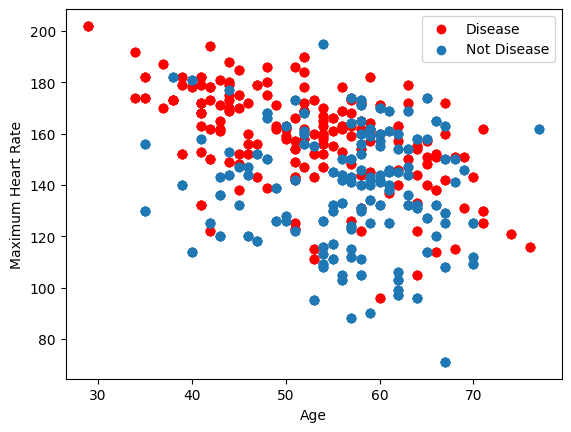

In [10]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

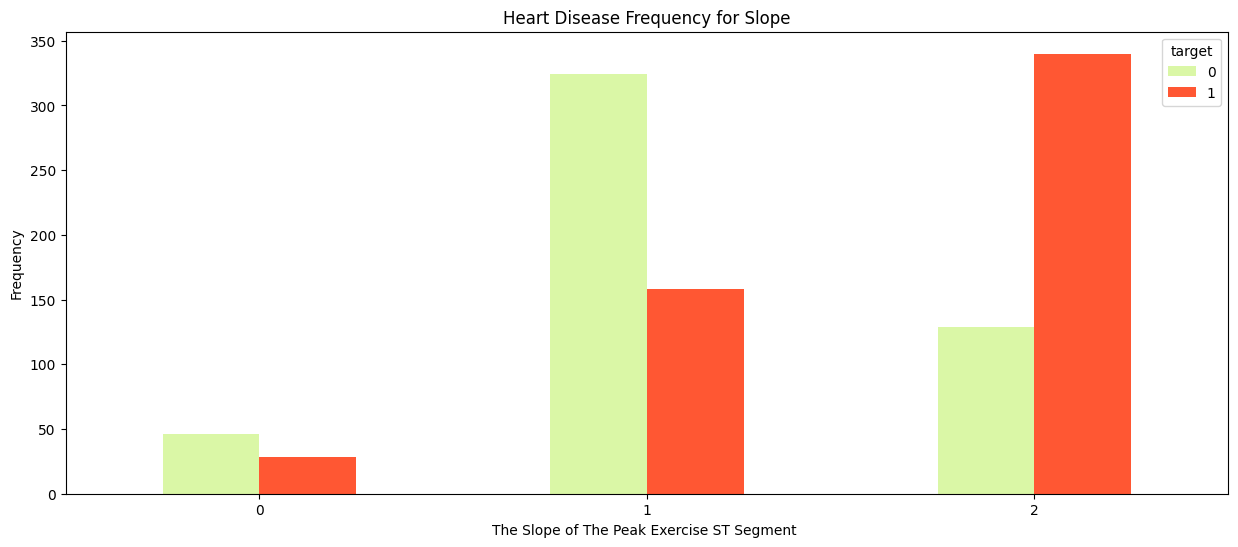

In [11]:
pd.crosstab(df.slope,df.target).plot(kind="bar", figsize=(15, 6), color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

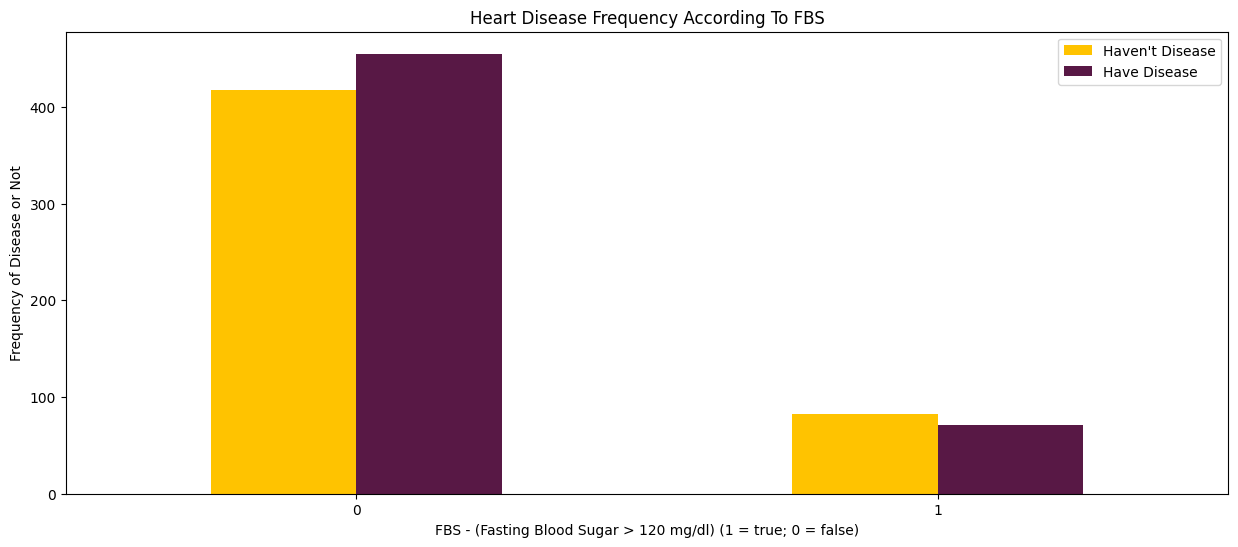

In [12]:
pd.crosstab(df.fbs,df.target).plot(kind="bar", figsize=(15, 6), color=['#FFC300','#581845' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

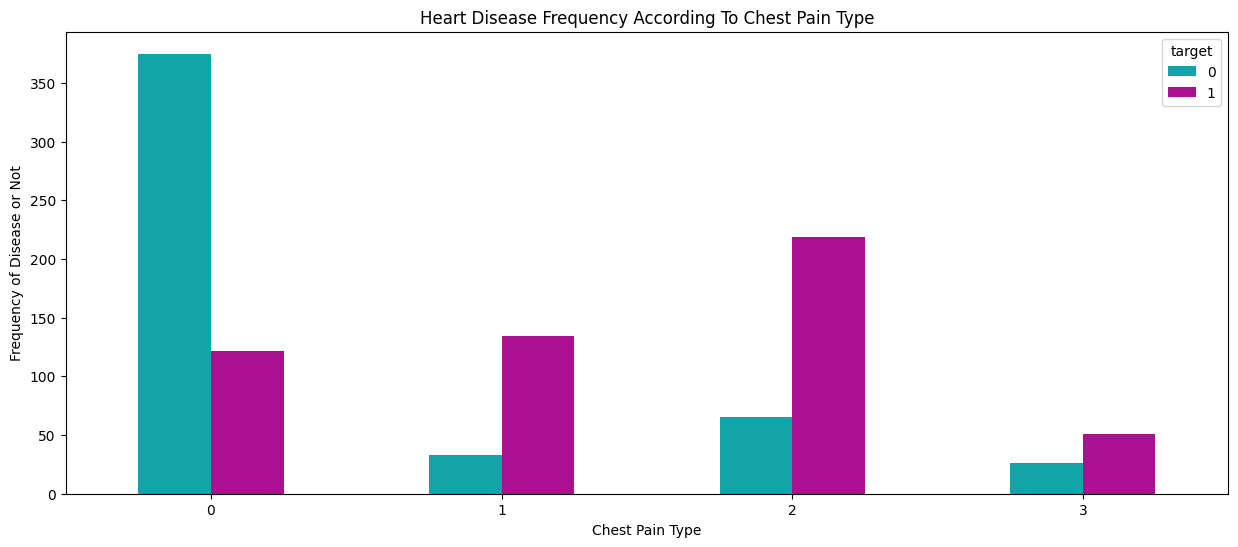

In [13]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15, 6), color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

### Преобразование категориальных признаков

Закодируем категориальные признаки **cp**, **thal** и **slope**.

In [14]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,0,125,212,0,1,168,0,1.0,...,0,0,0,0,0,0,1,0,0,1
1,53,1,0,140,203,1,0,155,1,3.1,...,0,0,0,0,0,0,1,1,0,0
2,70,1,0,145,174,0,1,125,1,2.6,...,0,0,0,0,0,0,1,1,0,0
3,61,1,0,148,203,0,1,161,0,0.0,...,0,0,0,0,0,0,1,0,0,1
4,62,0,0,138,294,1,1,106,0,1.9,...,0,0,0,0,0,1,0,0,1,0


In [15]:
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0


## Разбиение данных с использованием train_test_split и масштабирование

In [16]:
y = df['target']
X = df.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=128)

scaler = StandardScaler()

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)
# масштабируем тестовую выборку используя статистики обучающей выборки
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [17]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [18]:
rfecv = RFECV(estimator=RidgeClassifierCV())
rfecv.fit(X_train, y_train)
features = list(X_train.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", features)

Optimal features:  14
Selected features:  ['sex', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_1', 'cp_2', 'thal_2', 'thal_3', 'slope_1', 'slope_2']


In [19]:
X_train, X_test = X_train[features], X_test[features]

## OWN KNN realization


In [20]:
class MyOwnKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train, self.y_train = check_X_y(X_train, y_train)
        return self

    def predict(self, X_test):
        X_test = check_array(X_test)
        predictions = list()
        for x in X_test:
            predictions.append(self.get_class(self.get_neighbors_idx(x)))
        return predictions

    def get_neighbors_idx(self, x):
        neighbor_pos = 0
        distance_pos = 1
        distances = [(i, distance.euclidean(x, X)) for i, X in enumerate(self.X_train)]
        distances.sort(key=lambda x: x[distance_pos])
        neighbors_idx = [distances[i][neighbor_pos] for i in range(self.k)]
        return neighbors_idx

    def get_class(self, neighbors_idx):
        class_names = [self.y_train[i] for i in neighbors_idx]
        return Counter(class_names).most_common(1)[0][0]

    def get_params(self, deep=True):
        return {"k": self.k}

In [21]:
cv = StratifiedKFold(5, shuffle=True, random_state=128)
param_grid = [{"k":  list(filter(lambda x: x % 2 != 0, range(1, 31, 2)))}]

searcher = GridSearchCV(MyOwnKNN(), param_grid=param_grid, cv=cv, scoring="recall")

searcher = searcher.fit(X_train, y_train)

optimal_k_neighbors = searcher.best_params_["k"]
print("Optimal k =", optimal_k_neighbors)
print("Optimal score =", searcher.best_score_)

Optimal k = 1
Optimal score = 0.9810440577563865


## OWN SVM realization

In [22]:
class MyOwnSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0.1, lambd=0.1):
        self.alpha = alpha
        self.lambd = lambd

    def fit(self, X_train, y_train):
        self.X_train , self.y_train = check_X_y(X_train, y_train)
        y_train_labels = np.where(self.y_train <= 0, -1, 1)
        self.w = np.zeros(self.X_train.shape[1])
        self.b = 0
        for i, train_row in enumerate(self.X_train):
            dw = 0
            db = 0
            if y_train_labels[i] * (np.dot(train_row, self.w) - self.b) >= 1:
                dw = 2 * self.lambd * self.w
                db = 0
            else:
                dw = 2 * self.lambd * self.w - np.dot(train_row, y_train_labels[i])
                db = y_train_labels[i]
            self.w -= self.alpha * dw
            self.b -= self.alpha * db
        return self

    def predict(self, X_test):
        X_test = check_array(X_test)
        labels = np.sign(np.dot(X_test, self.w) - self.b)
        predictions = np.where(labels <= -1, 0, 1)
        return predictions

    def get_params(self, deep=True):
        return {"alpha": self.alpha,
                "lambd": self.lambd}

In [23]:
param_grid = [{"alpha": [0.1, 0.01, 0.001, 0.0001],
               "lambd": [0.1, 0.01, 0.001, 0.0001]}]

searcher = GridSearchCV(MyOwnSVM(), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_alpha = searcher.best_params_["alpha"]
print("Optimal alpha =", optimal_alpha)
optimal_lambd = searcher.best_params_["lambd"]
print("Optimal lambd =", optimal_lambd)
print("Optimal score =", searcher.best_score_)

Optimal alpha = 0.01
Optimal lambd = 0.1
Optimal score = 0.8507381507381508


## SVM from library

In [24]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=128), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 2, 'gamma': 1, 'kernel': 'rbf'}
Optimal score = 0.9706682206682208


## KNN from library

In [25]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'n_neighbors': 5, 'weights': 'distance'}
Optimal score = 0.9804195804195805


## LogisticRegression from library

In [26]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=128), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 10.0}
Optimal score = 0.8479700854700856


## Naive Bayes from library

In [27]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{"priors": [[0.5, 0.5], [0.33, 0.67], [0.67, 0.33], [0.25, 0.75], [0.75, 0.25]],
               "var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_priors = searcher.best_params_["priors"]
optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'priors': [0.25, 0.75], 'var_smoothing': 0.030538555088334154}
Optimal score = 0.8493492618492618


## Decision Tree from library

In [28]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=128), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'criterion': 'entropy', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Optimal score = 0.9427836052836053


# Test

In [29]:
ownKNN = MyOwnKNN(k = 1)
ownKNN.fit(X_train, y_train)
ownKNN_prediction = ownKNN.predict(X_test)

print("k = {} ownKNN Score: {:.4f}".format(1, ownKNN.score(X_test, y_test)))

k = 1 ownKNN Score: 0.9578


In [30]:
ownSVM = MyOwnSVM(alpha = 0.01, lambd = 0.1)
ownSVM.fit(X_train, y_train)
ownSVM_prediction = ownSVM.predict(X_test)

print("ownSVM Score: {:.4f}".format(ownSVM.score(X_test, y_test)))

ownSVM Score: 0.8279


In [31]:
KNN = KNeighborsClassifier(n_neighbors=5, weights='distance')
KNN.fit(X_train, y_train)
KNN_prediction = KNN.predict(X_test)

print("k = {} KNN Score: {:.4f}".format(5, KNN.score(X_test, y_test)))

k = 5 KNN Score: 0.9578


In [32]:
SVM = SVC(C=2, gamma=1, kernel='rbf')
SVM.fit(X_train, y_train)
SVM_prediction = SVM.predict(X_test)

print("SVM Score: {:.4f}".format(SVM.score(X_test, y_test)))

SVM Score: 0.9675


In [33]:
LR = LogisticRegression(C=10.0)
LR.fit(X_train, y_train)
LR_prediction = LR.predict(X_test)

print("LR Score: {:.4f}".format(LR.score(X_test, y_test)))

LR Score: 0.8312


In [34]:
NB = GaussianNB(priors=[0.25, 0.75], var_smoothing=0.030538555088334154)
NB.fit(X_train, y_train)
NB_prediction = NB.predict(X_test)

print("NB Score: {:.4f}".format(NB.score(X_test, y_test)))

NB Score: 0.8182


In [35]:
DT = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=5, splitter='best')
DT.fit(X_train, y_train)
DT_prediction = DT.predict(X_test)

print("DT Score: {:.4f}".format(DT.score(X_test, y_test)))

DT Score: 0.9481


# Compare models

In [36]:
from sklearn.metrics import confusion_matrix

cm_own_knn = confusion_matrix(y_test, ownKNN_prediction)
cm_own_svm = confusion_matrix(y_test, ownSVM_prediction)

cm_lr = confusion_matrix(y_test, LR_prediction)
cm_knn = confusion_matrix(y_test, KNN_prediction)
cm_svm = confusion_matrix(y_test, SVM_prediction)
cm_nb = confusion_matrix(y_test, NB_prediction)
cm_dtc = confusion_matrix(y_test, DT_prediction)

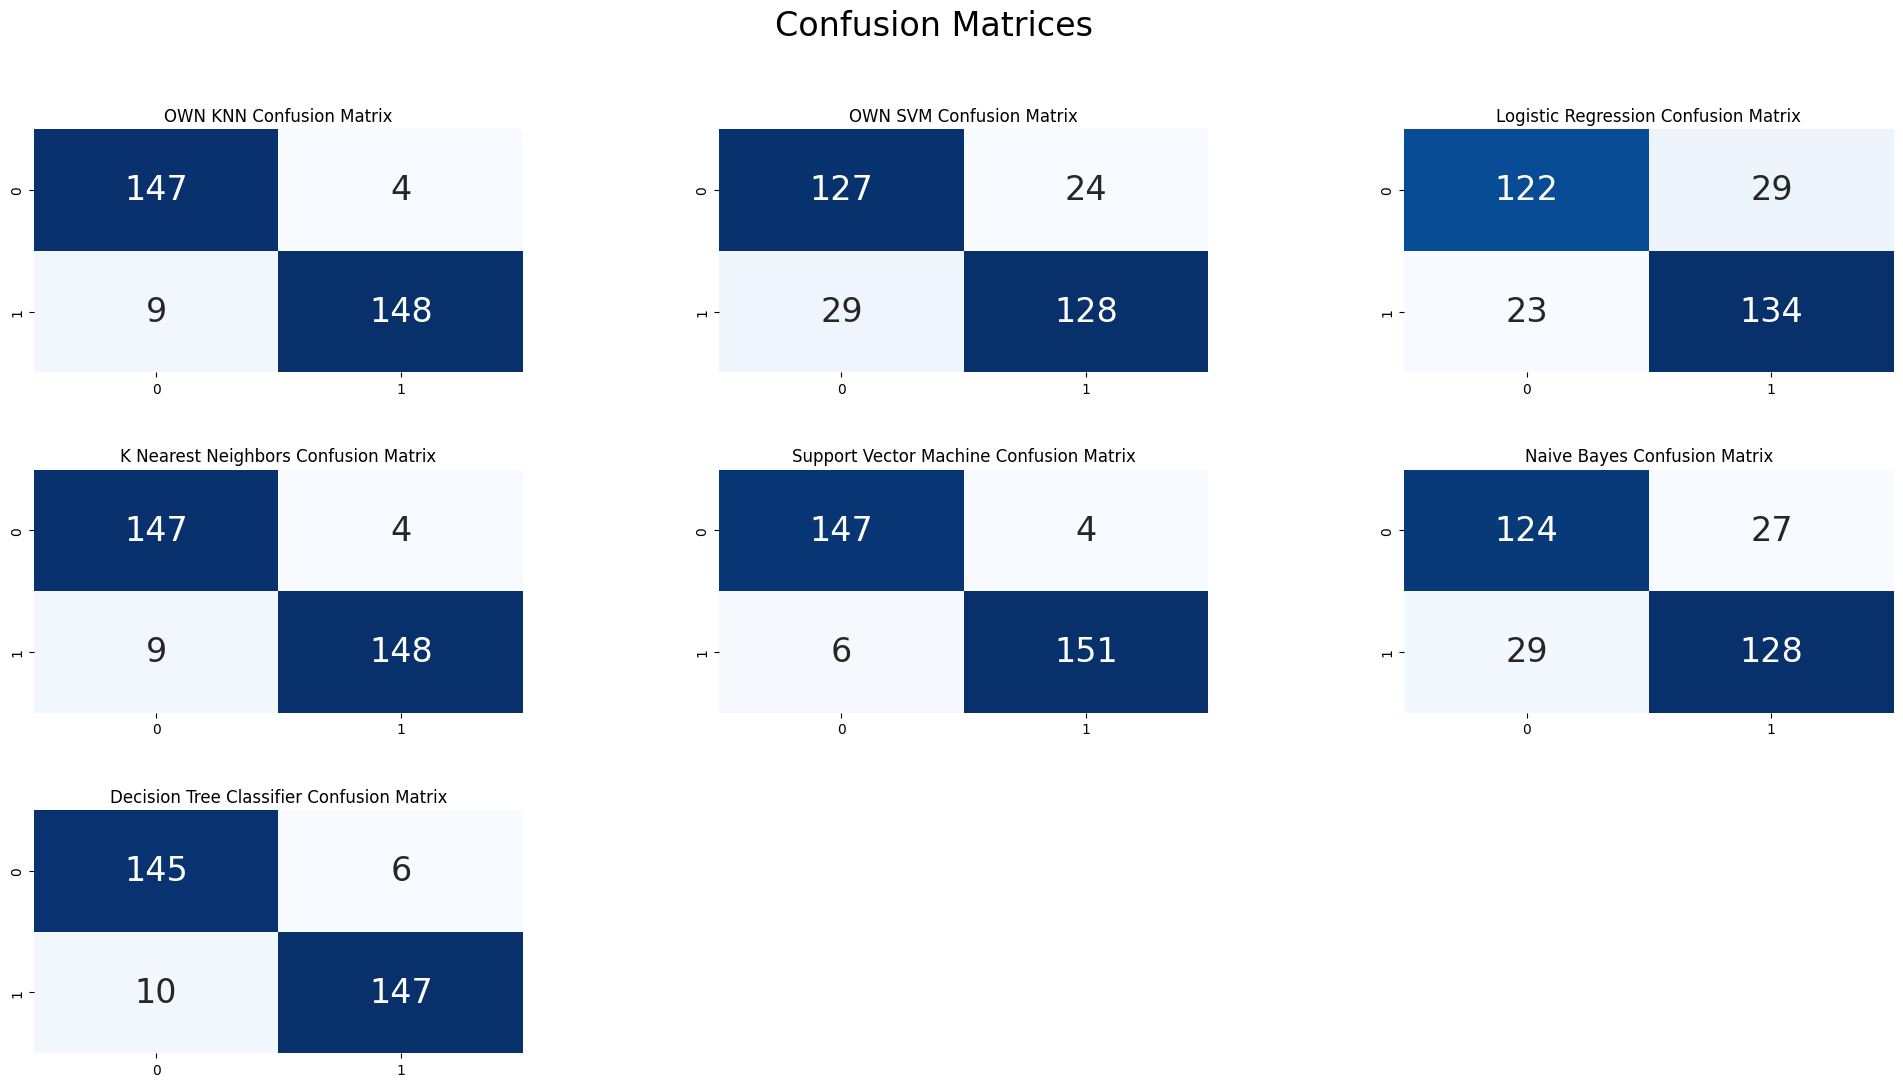

In [37]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)


plt.subplot(3,3,1)
plt.title("OWN KNN Confusion Matrix")
sns.heatmap(cm_own_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,2)
plt.title("OWN SVM Confusion Matrix")
sns.heatmap(cm_own_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})


plt.subplot(3,3,3)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,4)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,5)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,6)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,7)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

# Conclusion

Вывод: наилучшую классификацию удалось совершить с помощью KNN-метода, SVM-метода (библиотечная реализация) и метода дерева решений.

Собственная реализация метода К ближайших соседей получилась аналогичной библиотечной реализации и показала схожий результат.

Собственная реализация метода опорных векторов немного уступает библиотечной реализации, но показала такой же результат предсказания как и наивный байесовский классификатор и логистическая регрессия.


# ADDITION

Возьмем датасет из дз первой таски и подготовим его. Первичный анализ очень объемен признаков будет в файле дз первой таски.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [39]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

Датасет представляет из себя данные о продажах видеоигр

В датасете содержатся поля:

Name - название игры.

Platform - платформа, под которую была выпущена игра.

Year_of_Release - год выпуска игры.

Genre - жанр видеоигры.

Publisher - издатель игры.

NA_Sales, EU_Sales, JP_Sales - количество проданных экземпляров игры в миллионах единиц в Северной Америке, Европе и Японии соответственно.

Other_Sales - количество проданных экземпляров игры в миллионах единиц в остальном мире за исключением вышеперечисленных регионов.

Global_Sales - общее количество проданных экземпляров игры в миллионах единиц.

Critic_score — совокупная оценка, составленная сотрудниками Metacritic.

Critic_count — количество критиков, использованных для расчета Critic_score.

User_score — оценка подписчиков Metacritic.

User_count — количество пользователей, выставивших user_score.

Developer — сторона, ответственная за создание игры.

Rating - Рейтинги ESRB (возрастной ценз).


 **Целевым интересующим для нас полем будем считать Global_Sales_category**. Данный столбец будет представлять из себя категориальный признак из числового признака Global_Sales.

In [40]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [42]:
df.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [43]:
df.isnull().mean()

Name               0.000120
Platform           0.000000
Year_of_Release    0.016089
Genre              0.000120
Publisher          0.003230
NA_Sales           0.000000
EU_Sales           0.000000
JP_Sales           0.000000
Other_Sales        0.000000
Global_Sales       0.000000
Critic_Score       0.513308
Critic_Count       0.513308
User_Score         0.400981
User_Count         0.546025
Developer          0.396136
Rating             0.404869
dtype: float64

Т.к. пропуски в столбцах Name, Genre, Publisher и Year_of_Release не превышают 2%, то их можно просто удалить:

In [44]:
df['Name'].replace('  ', np.nan, inplace=True)
df= df.dropna(subset=['Name'])

df['Genre'].replace('  ', np.nan, inplace=True)
df= df.dropna(subset=['Genre'])

df['Year_of_Release'].replace('  ', np.nan, inplace=True)
df= df.dropna(subset=['Year_of_Release'])

df['Publisher'].replace('  ', np.nan, inplace=True)
df= df.dropna(subset=['Publisher'])

In [45]:
df.isnull().sum()

Name                  0
Platform              0
Year_of_Release       0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8434
Critic_Count       8434
User_Score         6579
User_Count         8955
Developer          6512
Rating             6649
dtype: int64

В остальных столбцах пропусков слишком много, поэтому заполним их "осмысленными" данными похожими на реальные. Предположим, что на оценки критиков и пользователей влияют жанр, платформа и год выпуска. На разработчика - его издатель. А на возрастной рейтинг жанр и издатель.

Поэтому более детально пройдемся по выбранным полям.

In [46]:
df['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [47]:
df['Genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [48]:
df['Publisher'].unique()

array(['Nintendo', 'Microsoft Game Studios', 'Take-Two Interactive',
       'Sony Computer Entertainment', 'Activision', 'Ubisoft',
       'Bethesda Softworks', 'Electronic Arts', 'Sega', 'SquareSoft',
       'Atari', '505 Games', 'Capcom', 'GT Interactive',
       'Konami Digital Entertainment', 'Square Enix',
       'Sony Computer Entertainment Europe', 'Virgin Interactive',
       'LucasArts', 'Warner Bros. Interactive Entertainment',
       'Universal Interactive', 'Eidos Interactive', 'RedOctane',
       'Vivendi Games', 'Enix Corporation', 'Namco Bandai Games',
       'Palcom', 'Hasbro Interactive', 'THQ', 'Fox Interactive',
       'Acclaim Entertainment', 'MTV Games', 'Disney Interactive Studios',
       'Codemasters', 'Majesco Entertainment', 'Red Orb', 'Level 5',
       'Arena Entertainment', 'Midway Games', 'JVC', 'Deep Silver',
       'NCSoft', '989 Studios', 'UEP Systems', 'Parker Bros.', 'Maxis',
       'Imagic', 'Tecmo Koei', 'ASCII Entertainment', 'Valve Software',
     

In [49]:
df['Publisher'].value_counts().to_dict()

{'Electronic Arts': 1344,
 'Activision': 976,
 'Namco Bandai Games': 935,
 'Ubisoft': 930,
 'Konami Digital Entertainment': 825,
 'THQ': 712,
 'Nintendo': 700,
 'Sony Computer Entertainment': 686,
 'Sega': 631,
 'Take-Two Interactive': 421,
 'Capcom': 381,
 'Atari': 351,
 'Tecmo Koei': 348,
 'Square Enix': 232,
 'Warner Bros. Interactive Entertainment': 220,
 'Disney Interactive Studios': 214,
 'Midway Games': 196,
 'Eidos Interactive': 196,
 '505 Games': 191,
 'Microsoft Game Studios': 191,
 'Acclaim Entertainment': 184,
 'D3Publisher': 183,
 'Vivendi Games': 161,
 'Codemasters': 148,
 'Idea Factory': 132,
 'Deep Silver': 120,
 'Nippon Ichi Software': 105,
 'Zoo Digital Publishing': 104,
 'Unknown': 99,
 'Majesco Entertainment': 90,
 'LucasArts': 89,
 'Rising Star Games': 86,
 'Hudson Soft': 81,
 'Bethesda Softworks': 74,
 'Banpresto': 73,
 'Crave Entertainment': 71,
 'Atlus': 67,
 '5pb': 62,
 'Virgin Interactive': 62,
 'Infogrames': 61,
 'Ignition Entertainment': 59,
 'Focus Home Int

In [50]:
df['Year_of_Release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983., 2020., 2017.])

In [51]:
df['Year_of_Release'].value_counts()

2008.0    1427
2009.0    1426
2010.0    1253
2007.0    1196
2011.0    1133
2006.0    1006
2005.0     934
2002.0     829
2003.0     775
2004.0     743
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     500
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
2017.0       3
2020.0       1
Name: Year_of_Release, dtype: int64

In [52]:
print(df['Year_of_Release'].min())
print(df['Year_of_Release'].max())

1980.0
2020.0


После рассмотрения данных полей хочется отметить, что из-за большой вариативности издателей и большого количества издателей с 1-5 играми поле издатель будет тяжело применить к определению оценок пользователей и критиков, поэтому для этого оно не будет применено.

Далее для удобства разобьем:

1) количественный признак года выпуска на категориальный: группами годов с 1980 по 2020 по 5 лет в группе (1980-1984, 1985-1989 и т.д.). П.с. т.к. в 2020 вышла всего одна игра - отнесем этот год к последней пятилетней группе.

2) платформы на группы. Выберем 3 группы платформ, PC - ПК и похожие устройства, Console - стационарные приставки, Portable console - мобильные и портативные приставки. Принадлежность платформе к той или иной группе установим по информации из интернета.


In [53]:
df['Year_category'] = 0  # заполняем сначала значения нового признака нулями
df.loc[(df['Year_of_Release'] >= 1980) & (df['Year_of_Release'] < 1985), 'Year_category'] = 1
df.loc[(df['Year_of_Release'] >= 1985) & (df['Year_of_Release'] < 1990), 'Year_category'] = 2
df.loc[(df['Year_of_Release'] >= 1990) & (df['Year_of_Release'] < 1995), 'Year_category'] = 3
df.loc[(df['Year_of_Release'] >= 1995) & (df['Year_of_Release'] < 2000), 'Year_category'] = 4
df.loc[(df['Year_of_Release'] >= 2000) & (df['Year_of_Release'] < 2005), 'Year_category'] = 5
df.loc[(df['Year_of_Release'] >= 2005) & (df['Year_of_Release'] < 2010), 'Year_category'] = 6
df.loc[(df['Year_of_Release'] >= 2010) & (df['Year_of_Release'] < 2015), 'Year_category'] = 7
df.loc[(df['Year_of_Release'] >= 2015) & (df['Year_of_Release'] <= 2020), 'Year_category'] =8

In [54]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Year_category
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,6
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,2
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,6
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,6
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,4


In [55]:
df['Platform_category'] = 0
df['Platform_category'] = df['Platform']
df['Platform_category'].\
replace(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'],\
        ['Portable_console', 'Console', 'Portable_console', 'Portable_console', 'Console', 'Console', 'Console', 'Console', 'Portable_console',
       'Console', 'Portable_console', 'Console', 'Console', 'Portable_console', 'PC', 'Console', 'Portable_console', 'Console',
       'Portable_console', 'Console', 'Console', 'Console', 'Portable_console', 'Console', 'Console', 'Portable_console', 'Portable_console', 'Console',
       'Console', 'Portable_console', 'Console'], inplace=True)
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Year_category,Platform_category
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,6,Portable_console
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,2,Console
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,6,Portable_console
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,6,Portable_console
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,4,Portable_console


In [56]:
df['Platform_category'].value_counts()

Console             8070
Portable_console    7394
PC                   952
Name: Platform_category, dtype: int64

In [57]:
df['Platform_category'].replace(['PC', 'Console', 'Portable_console'], [1, 2, 3], inplace=True)

In [58]:
df['Platform_category'].value_counts()

2    8070
3    7394
1     952
Name: Platform_category, dtype: int64

In [59]:
df['Genre_int'] = 0
df['Genre_int'] = df['Genre']
df['Genre_int'].\
replace(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'],\
        [x for x in range(1, len(df['Genre'].unique().tolist())+1)], inplace=True)
df['Genre_int'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [60]:
not_null_df = df[df["Critic_Score"].notnull()]
yc_len = len(df["Year_category"].unique())
pc_len = len(df["Platform_category"].unique())
g_len = len(df["Genre_int"].unique())

matrix3d = [[ [list() for col in range(yc_len)] for col in range(pc_len)] for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1].append(row["Critic_Score"])

matrix_genre = [list() for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix_genre[row["Genre_int"]-1].append(row["Critic_Score"])

In [61]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["Critic_Score"]):
    continue
  item = matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1]
  if len(item) != 0:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'Critic_Score'] = val
    continue
  item = matrix_genre[row["Genre_int"]-1]
  if len(item) != 0:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'Critic_Score'] = val
    continue
  val = 50
  df.at[i,'Critic_Score'] = val

In [62]:
not_null_df = df[df["Critic_Count"].notnull()]

matrix3d = [[ [list() for col in range(yc_len)] for col in range(pc_len)] for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1].append(row["Critic_Count"])

matrix_genre = [list() for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix_genre[row["Genre_int"]-1].append(row["Critic_Count"])

In [63]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["Critic_Count"]):
    continue
  item = matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1]
  if len(item) != 0:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'Critic_Count'] = val
    continue
  item = matrix_genre[row["Genre_int"]-1]
  if len(item) != 0:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'Critic_Count'] = val
    continue
  val = 50
  df.at[i,'Critic_Count'] = val

In [64]:
not_null_df = df[df["User_Score"].notnull()]

matrix3d = [[ [list() for col in range(yc_len)] for col in range(pc_len)] for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1].append(row["User_Score"])

matrix_genre = [list() for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix_genre[row["Genre_int"]-1].append(row["User_Score"])

In [65]:
print(len(df[df['User_Score']=='tbd']))

2376


In [66]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["User_Score"]):
    if row["User_Score"] == 'tbd':
      val = randint(3, 7)
      df.at[i,'User_Score'] = val
      continue
    else:
      continue
  item = matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1]
  item = [float(e) for e in item if e.isdigit()]
  if item != []:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'User_Score'] = val
    continue
  item = matrix_genre[row["Genre_int"]-1]
  item = [float(e) for e in item if e.isdigit()]
  if item != []:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'User_Score'] = val
    continue
  val = randint(3, 7)
  df.at[i,'User_Score'] = val

df[['User_Score']] = df[['User_Score']].astype(float)

In [67]:
print(len(df[df['User_Score']=='tbd']))

0


In [68]:
not_null_df = df[df["User_Count"].notnull()]

matrix3d = [[ [list() for col in range(yc_len)] for col in range(pc_len)] for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1].append(row["User_Count"])

matrix_genre = [list() for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix_genre[row["Genre_int"]-1].append(row["User_Count"])

In [69]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["User_Count"]):
    continue
  item = matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1]
  if item != []:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'User_Count'] = val
    continue
  item = matrix_genre[row["Genre_int"]-1]
  if item != []:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'User_Count'] = val
    continue
  val = 50
  df.at[i,'User_Count'] = val

In [70]:
not_null_df = df[df["Developer"].notnull()]
pub_len = len(df["Publisher"].unique())

matrix_pub = dict()
for i, row in not_null_df.iterrows():
  if matrix_pub.get(row["Publisher"]) == None:
    matrix_pub[row["Publisher"]] = list()
  matrix_pub[row["Publisher"]].append(row["Developer"])

In [71]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["Developer"]):
    continue
  item = matrix_pub.get(row["Publisher"])
  if item != None and item != []:
    max = len(item) - 1
    val = randint(0, max)
    df.at[i,'Developer'] = item[val]
    continue
  val = "Other"
  df.at[i,'Developer'] = val

In [72]:
df[df["Rating"].notnull()]["Rating"].value_counts()

E       3921
T       2904
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: Rating, dtype: int64

In [73]:
not_null_df = df[df["Rating"].notnull()]

matrix_pub = dict()
for i, row in not_null_df.iterrows():
  if matrix_pub.get(row["Genre"]) == None:
    matrix_pub[row["Genre"]] = list()
  matrix_pub[row["Genre"]].append(row["Rating"])

In [74]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["Rating"]):
    continue
  item = matrix_pub.get(row["Genre"])
  if item != None and item != []:
    max = len(item) - 1
    val = randint(0, max)
    df.at[i,'Rating'] = item[val]
    continue
  val = "E"
  df.at[i,'Rating'] = val

In [75]:
df.isnull().sum()

Name                 0
Platform             0
Year_of_Release      0
Genre                0
Publisher            0
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score         0
Critic_Count         0
User_Score           0
User_Count           0
Developer            0
Rating               0
Year_category        0
Platform_category    0
Genre_int            0
dtype: int64

### Создадим новый, указанный нами целевым, признак **Global_Sales_category**

0.02     1064
0.03      835
0.04      640
0.05      622
0.01      621
         ... 
5.15        1
5.16        1
5.20        1
3.56        1
82.53       1
Name: Global_Sales, Length: 628, dtype: int64
max = {} 82.53
min = {} 0.01


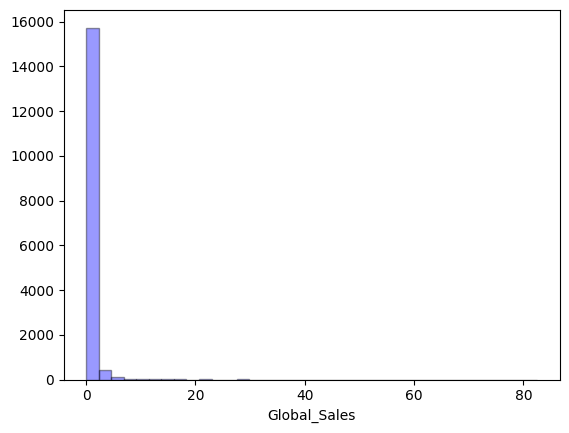

In [76]:
sns.distplot(df['Global_Sales'], hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
print(df['Global_Sales'].value_counts())
print("max = {}", df['Global_Sales'].max())
print("min = {}", df['Global_Sales'].min())

<Axes: xlabel='Global_Sales_normal'>

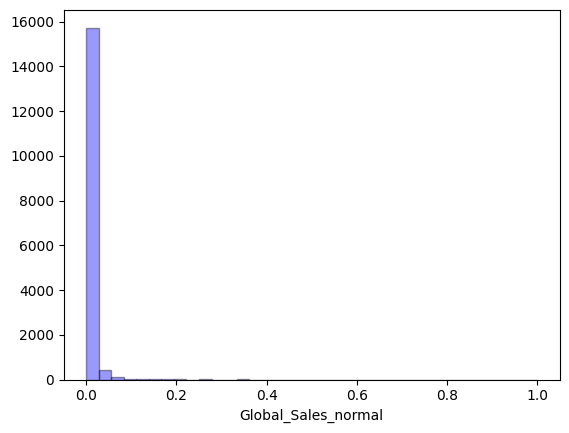

In [77]:
df['Global_Sales_normal'] = 0  # заполняем сначала значения нового признака нулями
GS_max = df['Global_Sales'].max()
for i, row in df.iterrows():
  df['Global_Sales_normal'] = df['Global_Sales'] / GS_max

sns.distplot(df['Global_Sales_normal'], hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

low_sales     8107
mid_sales     5325
high_sales    1888
bestseller    1096
Name: Global_Sales_category, dtype: int64


<Axes: >

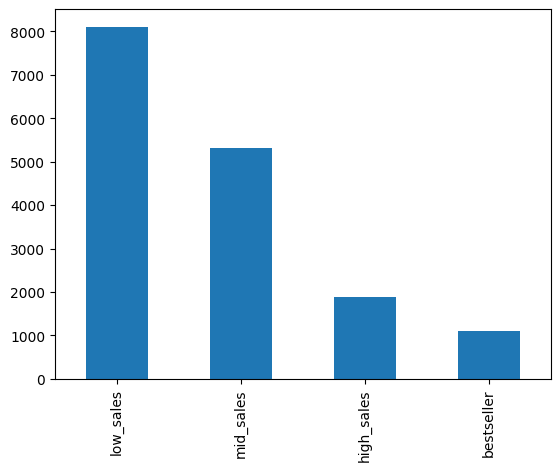

In [78]:
df['Global_Sales_category'] = 0  # заполняем сначала значения нового признака нулями
df.loc[(df['Global_Sales_normal'] < 0.002), 'Global_Sales_category'] = "low_sales"
df.loc[(df['Global_Sales_normal'] >= 0.002) & (df['Global_Sales_normal'] < 0.008), 'Global_Sales_category'] = "mid_sales"
df.loc[(df['Global_Sales_normal'] >= 0.008) & (df['Global_Sales_normal'] < 0.02), 'Global_Sales_category'] = "high_sales"
df.loc[(df['Global_Sales_normal'] >= 0.02), 'Global_Sales_category'] = "bestseller"
vc = df['Global_Sales_category'].value_counts()
print(vc)
vc.plot(kind='bar')

Удалим колонку с именем, т.к. она лишняя для анализа

In [79]:
df = df.drop(columns=['Name'])
df

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Year_category,Platform_category,Genre_int,Global_Sales_normal,Global_Sales_category
0,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,6,3,1,1.000000,bestseller
1,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,49.0,52.0,5.0,1199.0,Nintendo,E,2,2,2,0.487580,bestseller
2,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,6,3,3,0.430389,bestseller
3,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,6,3,1,0.397068,bestseller
4,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,96.0,26.0,6.0,4351.0,Mistwalker,T,4,3,4,0.380104,bestseller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,63.0,91.0,6.0,781.0,Omega Force,M,8,2,9,0.000121,low_sales
16715,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,32.0,5.0,5.0,96.0,Codemasters,E,6,2,1,0.000121,low_sales
16716,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,81.0,7.0,7.0,32.0,Idea Factory,E,8,3,11,0.000121,low_sales
16717,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,38.0,29.0,8.0,88.0,Babylon Software,E10+,5,3,2,0.000121,low_sales


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16416 entries, 0 to 16718
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Platform               16416 non-null  object 
 1   Year_of_Release        16416 non-null  float64
 2   Genre                  16416 non-null  object 
 3   Publisher              16416 non-null  object 
 4   NA_Sales               16416 non-null  float64
 5   EU_Sales               16416 non-null  float64
 6   JP_Sales               16416 non-null  float64
 7   Other_Sales            16416 non-null  float64
 8   Global_Sales           16416 non-null  float64
 9   Critic_Score           16416 non-null  float64
 10  Critic_Count           16416 non-null  float64
 11  User_Score             16416 non-null  float64
 12  User_Count             16416 non-null  float64
 13  Developer              16416 non-null  object 
 14  Rating                 16416 non-null  object 
 15  Ye

In [81]:
df.isnull().sum()

Platform                 0
Year_of_Release          0
Genre                    0
Publisher                0
NA_Sales                 0
EU_Sales                 0
JP_Sales                 0
Other_Sales              0
Global_Sales             0
Critic_Score             0
Critic_Count             0
User_Score               0
User_Count               0
Developer                0
Rating                   0
Year_category            0
Platform_category        0
Genre_int                0
Global_Sales_normal      0
Global_Sales_category    0
dtype: int64

In [82]:
df.isnull().mean()

Platform                 0.0
Year_of_Release          0.0
Genre                    0.0
Publisher                0.0
NA_Sales                 0.0
EU_Sales                 0.0
JP_Sales                 0.0
Other_Sales              0.0
Global_Sales             0.0
Critic_Score             0.0
Critic_Count             0.0
User_Score               0.0
User_Count               0.0
Developer                0.0
Rating                   0.0
Year_category            0.0
Platform_category        0.0
Genre_int                0.0
Global_Sales_normal      0.0
Global_Sales_category    0.0
dtype: float64

Т.к. пропуски в столбцах Name, Genre, Publisher и Year_of_Release не превышают 2%, то их можно просто удалить:

In [83]:
df['Genre'].replace('  ', np.nan, inplace=True)
df= df.dropna(subset=['Genre'])

df['Year_of_Release'].replace('  ', np.nan, inplace=True)
df= df.dropna(subset=['Year_of_Release'])

df['Publisher'].replace('  ', np.nan, inplace=True)
df= df.dropna(subset=['Publisher'])

In [84]:
df.isnull().sum()

Platform                 0
Year_of_Release          0
Genre                    0
Publisher                0
NA_Sales                 0
EU_Sales                 0
JP_Sales                 0
Other_Sales              0
Global_Sales             0
Critic_Score             0
Critic_Count             0
User_Score               0
User_Count               0
Developer                0
Rating                   0
Year_category            0
Platform_category        0
Genre_int                0
Global_Sales_normal      0
Global_Sales_category    0
dtype: int64

В остальных столбцах пропусков слишком много, поэтому заполним их "осмысленными" данными похожими на реальные. Предположим, что на оценки критиков и пользователей влияют жанр, платформа и год выпуска. На разработчика - его издатель. А на возрастной рейтинг жанр и издатель.

Поэтому более детально пройдемся по выбранным полям.

In [85]:
df['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [86]:
df['Genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [87]:
df['Publisher'].unique()

array(['Nintendo', 'Microsoft Game Studios', 'Take-Two Interactive',
       'Sony Computer Entertainment', 'Activision', 'Ubisoft',
       'Bethesda Softworks', 'Electronic Arts', 'Sega', 'SquareSoft',
       'Atari', '505 Games', 'Capcom', 'GT Interactive',
       'Konami Digital Entertainment', 'Square Enix',
       'Sony Computer Entertainment Europe', 'Virgin Interactive',
       'LucasArts', 'Warner Bros. Interactive Entertainment',
       'Universal Interactive', 'Eidos Interactive', 'RedOctane',
       'Vivendi Games', 'Enix Corporation', 'Namco Bandai Games',
       'Palcom', 'Hasbro Interactive', 'THQ', 'Fox Interactive',
       'Acclaim Entertainment', 'MTV Games', 'Disney Interactive Studios',
       'Codemasters', 'Majesco Entertainment', 'Red Orb', 'Level 5',
       'Arena Entertainment', 'Midway Games', 'JVC', 'Deep Silver',
       'NCSoft', '989 Studios', 'UEP Systems', 'Parker Bros.', 'Maxis',
       'Imagic', 'Tecmo Koei', 'ASCII Entertainment', 'Valve Software',
     

In [88]:
df['Publisher'].value_counts().to_dict()

{'Electronic Arts': 1344,
 'Activision': 976,
 'Namco Bandai Games': 935,
 'Ubisoft': 930,
 'Konami Digital Entertainment': 825,
 'THQ': 712,
 'Nintendo': 700,
 'Sony Computer Entertainment': 686,
 'Sega': 631,
 'Take-Two Interactive': 421,
 'Capcom': 381,
 'Atari': 351,
 'Tecmo Koei': 348,
 'Square Enix': 232,
 'Warner Bros. Interactive Entertainment': 220,
 'Disney Interactive Studios': 214,
 'Midway Games': 196,
 'Eidos Interactive': 196,
 '505 Games': 191,
 'Microsoft Game Studios': 191,
 'Acclaim Entertainment': 184,
 'D3Publisher': 183,
 'Vivendi Games': 161,
 'Codemasters': 148,
 'Idea Factory': 132,
 'Deep Silver': 120,
 'Nippon Ichi Software': 105,
 'Zoo Digital Publishing': 104,
 'Unknown': 99,
 'Majesco Entertainment': 90,
 'LucasArts': 89,
 'Rising Star Games': 86,
 'Hudson Soft': 81,
 'Bethesda Softworks': 74,
 'Banpresto': 73,
 'Crave Entertainment': 71,
 'Atlus': 67,
 '5pb': 62,
 'Virgin Interactive': 62,
 'Infogrames': 61,
 'Ignition Entertainment': 59,
 'Focus Home Int

In [89]:
df['Year_of_Release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983., 2020., 2017.])

In [90]:
df['Year_of_Release'].value_counts()

2008.0    1427
2009.0    1426
2010.0    1253
2007.0    1196
2011.0    1133
2006.0    1006
2005.0     934
2002.0     829
2003.0     775
2004.0     743
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     500
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
2017.0       3
2020.0       1
Name: Year_of_Release, dtype: int64

In [91]:
print(df['Year_of_Release'].min())
print(df['Year_of_Release'].max())

1980.0
2020.0


После рассмотрения данных полей хочется отметить, что из-за большой вариативности издателей и большого количества издателей с 1-5 играми поле издатель будет тяжело применить к определению оценок пользователей и критиков, поэтому для этого оно не будет применено.

Далее для удобства разобьем:

1) количественный признак года выпуска на категориальный: группами годов с 1980 по 2020 по 5 лет в группе (1980-1984, 1985-1989 и т.д.). П.с. т.к. в 2020 вышла всего одна игра - отнесем этот год к последней пятилетней группе.

2) платформы на группы. Выберем 3 группы платформ, PC - ПК и похожие устройства, Console - стационарные приставки, Portable console - мобильные и портативные приставки. Принадлежность платформе к той или иной группе установим по информации из интернета.


In [92]:
df['Year_category'] = 0  # заполняем сначала значения нового признака нулями
df.loc[(df['Year_of_Release'] >= 1980) & (df['Year_of_Release'] < 1985), 'Year_category'] = 1
df.loc[(df['Year_of_Release'] >= 1985) & (df['Year_of_Release'] < 1990), 'Year_category'] = 2
df.loc[(df['Year_of_Release'] >= 1990) & (df['Year_of_Release'] < 1995), 'Year_category'] = 3
df.loc[(df['Year_of_Release'] >= 1995) & (df['Year_of_Release'] < 2000), 'Year_category'] = 4
df.loc[(df['Year_of_Release'] >= 2000) & (df['Year_of_Release'] < 2005), 'Year_category'] = 5
df.loc[(df['Year_of_Release'] >= 2005) & (df['Year_of_Release'] < 2010), 'Year_category'] = 6
df.loc[(df['Year_of_Release'] >= 2010) & (df['Year_of_Release'] < 2015), 'Year_category'] = 7
df.loc[(df['Year_of_Release'] >= 2015) & (df['Year_of_Release'] <= 2020), 'Year_category'] =8

In [93]:
df.head()

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Year_category,Platform_category,Genre_int,Global_Sales_normal,Global_Sales_category
0,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,6,3,1,1.000000,bestseller
1,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,49.0,52.0,5.0,1199.0,Nintendo,E,2,2,2,0.487580,bestseller
2,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,6,3,3,0.430389,bestseller
3,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,6,3,1,0.397068,bestseller
4,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,96.0,26.0,6.0,4351.0,Mistwalker,T,4,3,4,0.380104,bestseller


In [94]:
df['Platform_category'] = 0
df['Platform_category'] = df['Platform']
df['Platform_category'].\
replace(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'],\
        ['Portable_console', 'Console', 'Portable_console', 'Portable_console', 'Console', 'Console', 'Console', 'Console', 'Portable_console',
       'Console', 'Portable_console', 'Console', 'Console', 'Portable_console', 'PC', 'Console', 'Portable_console', 'Console',
       'Portable_console', 'Console', 'Console', 'Console', 'Portable_console', 'Console', 'Console', 'Portable_console', 'Portable_console', 'Console',
       'Console', 'Portable_console', 'Console'], inplace=True)
df.head()

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Year_category,Platform_category,Genre_int,Global_Sales_normal,Global_Sales_category
0,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,6,Portable_console,1,1.000000,bestseller
1,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,49.0,52.0,5.0,1199.0,Nintendo,E,2,Console,2,0.487580,bestseller
2,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,6,Portable_console,3,0.430389,bestseller
3,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,6,Portable_console,1,0.397068,bestseller
4,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,96.0,26.0,6.0,4351.0,Mistwalker,T,4,Portable_console,4,0.380104,bestseller


In [95]:
df['Platform_category'].value_counts()

Console             8070
Portable_console    7394
PC                   952
Name: Platform_category, dtype: int64

In [96]:
df['Platform_category'].replace(['PC', 'Console', 'Portable_console'], [1, 2, 3], inplace=True)

In [97]:
df['Platform_category'].value_counts()

2    8070
3    7394
1     952
Name: Platform_category, dtype: int64

In [98]:
df['Genre_int'] = 0
df['Genre_int'] = df['Genre']
df['Genre_int'].\
replace(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'],\
        [x for x in range(1, len(df['Genre'].unique().tolist())+1)], inplace=True)
df['Genre_int'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [99]:
not_null_df = df[df["Critic_Score"].notnull()]
yc_len = len(df["Year_category"].unique())
pc_len = len(df["Platform_category"].unique())
g_len = len(df["Genre_int"].unique())

matrix3d = [[ [list() for col in range(yc_len)] for col in range(pc_len)] for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1].append(row["Critic_Score"])

matrix_genre = [list() for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix_genre[row["Genre_int"]-1].append(row["Critic_Score"])

In [100]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["Critic_Score"]):
    continue
  item = matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1]
  if len(item) != 0:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'Critic_Score'] = val
    continue
  item = matrix_genre[row["Genre_int"]-1]
  if len(item) != 0:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'Critic_Score'] = val
    continue
  val = 50
  df.at[i,'Critic_Score'] = val

In [101]:
not_null_df = df[df["Critic_Count"].notnull()]

matrix3d = [[ [list() for col in range(yc_len)] for col in range(pc_len)] for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1].append(row["Critic_Count"])

matrix_genre = [list() for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix_genre[row["Genre_int"]-1].append(row["Critic_Count"])

In [102]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["Critic_Count"]):
    continue
  item = matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1]
  if len(item) != 0:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'Critic_Count'] = val
    continue
  item = matrix_genre[row["Genre_int"]-1]
  if len(item) != 0:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'Critic_Count'] = val
    continue
  val = 50
  df.at[i,'Critic_Count'] = val

In [103]:
not_null_df = df[df["User_Score"].notnull()]

matrix3d = [[ [list() for col in range(yc_len)] for col in range(pc_len)] for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1].append(row["User_Score"])

matrix_genre = [list() for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix_genre[row["Genre_int"]-1].append(row["User_Score"])

In [104]:
print(len(df[df['User_Score']=='tbd']))

0


In [105]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["User_Score"]):
    if row["User_Score"] == 'tbd':
      val = randint(3, 7)
      df.at[i,'User_Score'] = val
      continue
    else:
      continue
  item = matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1]
  item = [float(e) for e in item if e.isdigit()]
  if item != []:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'User_Score'] = val
    continue
  item = matrix_genre[row["Genre_int"]-1]
  item = [float(e) for e in item if e.isdigit()]
  if item != []:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'User_Score'] = val
    continue
  val = randint(3, 7)
  df.at[i,'User_Score'] = val

df[['User_Score']] = df[['User_Score']].astype(float)

In [106]:
print(len(df[df['User_Score']=='tbd']))

0


In [107]:
not_null_df = df[df["User_Count"].notnull()]

matrix3d = [[ [list() for col in range(yc_len)] for col in range(pc_len)] for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1].append(row["User_Count"])

matrix_genre = [list() for col in range(g_len)]
for i, row in not_null_df.iterrows():
  matrix_genre[row["Genre_int"]-1].append(row["User_Count"])

In [108]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["User_Count"]):
    continue
  item = matrix3d[row["Genre_int"]-1][row["Platform_category"]-1][row["Year_category"]-1]
  if item != []:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'User_Count'] = val
    continue
  item = matrix_genre[row["Genre_int"]-1]
  if item != []:
    min = np.min(item)
    max = np.max(item)
    val = randint(min, max)
    df.at[i,'User_Count'] = val
    continue
  val = 50
  df.at[i,'User_Count'] = val

In [109]:
not_null_df = df[df["Developer"].notnull()]
pub_len = len(df["Publisher"].unique())

matrix_pub = dict()
for i, row in not_null_df.iterrows():
  if matrix_pub.get(row["Publisher"]) == None:
    matrix_pub[row["Publisher"]] = list()
  matrix_pub[row["Publisher"]].append(row["Developer"])

In [110]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["Developer"]):
    continue
  item = matrix_pub.get(row["Publisher"])
  if item != None and item != []:
    max = len(item) - 1
    val = randint(0, max)
    df.at[i,'Developer'] = item[val]
    continue
  val = "Other"
  df.at[i,'Developer'] = val

In [111]:
df[df["Rating"].notnull()]["Rating"].value_counts()

E       6516
T       5033
M       2423
E10+    2417
EC        15
K-A        8
RP         3
AO         1
Name: Rating, dtype: int64

In [112]:
not_null_df = df[df["Rating"].notnull()]

matrix_pub = dict()
for i, row in not_null_df.iterrows():
  if matrix_pub.get(row["Genre"]) == None:
    matrix_pub[row["Genre"]] = list()
  matrix_pub[row["Genre"]].append(row["Rating"])

In [113]:
from math import nan
from random import randint

for i, row in df.iterrows():
  if pd.notnull(row["Rating"]):
    continue
  item = matrix_pub.get(row["Genre"])
  if item != None and item != []:
    max = len(item) - 1
    val = randint(0, max)
    df.at[i,'Rating'] = item[val]
    continue
  val = "E"
  df.at[i,'Rating'] = val

In [114]:
df.isnull().sum()

Platform                 0
Year_of_Release          0
Genre                    0
Publisher                0
NA_Sales                 0
EU_Sales                 0
JP_Sales                 0
Other_Sales              0
Global_Sales             0
Critic_Score             0
Critic_Count             0
User_Score               0
User_Count               0
Developer                0
Rating                   0
Year_category            0
Platform_category        0
Genre_int                0
Global_Sales_normal      0
Global_Sales_category    0
dtype: int64

### Создадим новый, указанный нами целевым, признак **Global_Sales_category**

0.02     1064
0.03      835
0.04      640
0.05      622
0.01      621
         ... 
5.15        1
5.16        1
5.20        1
3.56        1
82.53       1
Name: Global_Sales, Length: 628, dtype: int64
max = {} 82.53
min = {} 0.01


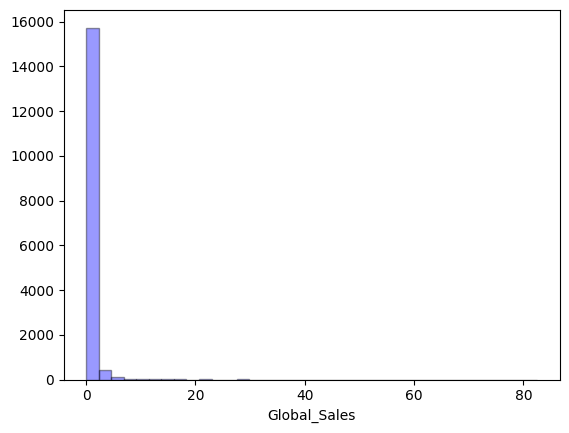

In [115]:
sns.distplot(df['Global_Sales'], hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
print(df['Global_Sales'].value_counts())
print("max = {}", df['Global_Sales'].max())
print("min = {}", df['Global_Sales'].min())

<Axes: xlabel='Global_Sales_normal'>

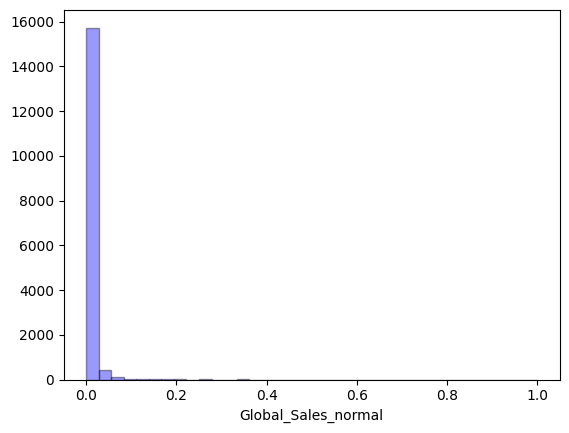

In [116]:
df['Global_Sales_normal'] = 0  # заполняем сначала значения нового признака нулями
GS_max = df['Global_Sales'].max()
for i, row in df.iterrows():
  df['Global_Sales_normal'] = df['Global_Sales'] / GS_max

sns.distplot(df['Global_Sales_normal'], hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

low_sales     8107
mid_sales     5325
high_sales    1888
bestseller    1096
Name: Global_Sales_category, dtype: int64


<Axes: >

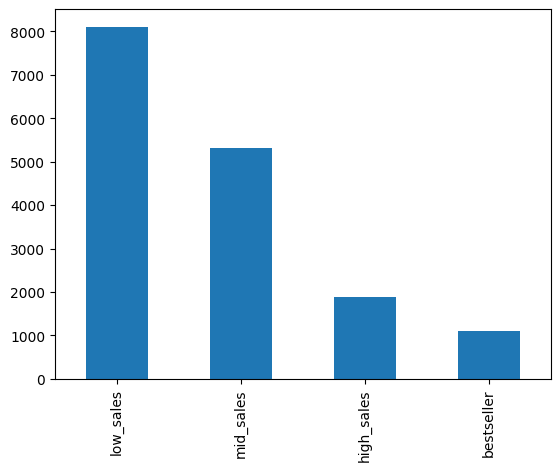

In [117]:
df['Global_Sales_category'] = 0  # заполняем сначала значения нового признака нулями
df.loc[(df['Global_Sales_normal'] < 0.002), 'Global_Sales_category'] = "low_sales"
df.loc[(df['Global_Sales_normal'] >= 0.002) & (df['Global_Sales_normal'] < 0.008), 'Global_Sales_category'] = "mid_sales"
df.loc[(df['Global_Sales_normal'] >= 0.008) & (df['Global_Sales_normal'] < 0.02), 'Global_Sales_category'] = "high_sales"
df.loc[(df['Global_Sales_normal'] >= 0.02), 'Global_Sales_category'] = "bestseller"
vc = df['Global_Sales_category'].value_counts()
print(vc)
vc.plot(kind='bar')

In [118]:
df.head()

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Year_category,Platform_category,Genre_int,Global_Sales_normal,Global_Sales_category
0,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,6,3,1,1.000000,bestseller
1,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,49.0,52.0,5.0,1199.0,Nintendo,E,2,2,2,0.487580,bestseller
2,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,6,3,3,0.430389,bestseller
3,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,6,3,1,0.397068,bestseller
4,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,96.0,26.0,6.0,4351.0,Mistwalker,T,4,3,4,0.380104,bestseller


In [119]:
df = df.drop(columns=["Platform", "Year_of_Release", "Genre", "Publisher", "Developer", "Rating"])

In [120]:
df['Global_Sales_category'].replace(['low_sales', "mid_sales", "high_sales", "bestseller"], [1, 2, 3, 4], inplace=True)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16416 entries, 0 to 16718
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NA_Sales               16416 non-null  float64
 1   EU_Sales               16416 non-null  float64
 2   JP_Sales               16416 non-null  float64
 3   Other_Sales            16416 non-null  float64
 4   Global_Sales           16416 non-null  float64
 5   Critic_Score           16416 non-null  float64
 6   Critic_Count           16416 non-null  float64
 7   User_Score             16416 non-null  float64
 8   User_Count             16416 non-null  float64
 9   Year_category          16416 non-null  int64  
 10  Platform_category      16416 non-null  int64  
 11  Genre_int              16416 non-null  int64  
 12  Global_Sales_normal    16416 non-null  float64
 13  Global_Sales_category  16416 non-null  int64  
dtypes: float64(10), int64(4)
memory usage: 2.4 MB


## Разбиение данных с использованием train_test_split и масштабирование

In [122]:
y = df['Global_Sales_category']
X = df.drop(columns=['Global_Sales_category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=128)

scaler = StandardScaler()

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)
# масштабируем тестовую выборку используя статистики обучающей выборки
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [123]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [124]:
rfecv = RFECV(estimator=RidgeClassifierCV())
rfecv.fit(X_train, y_train)
features = list(X_train.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", features)

Optimal features:  12
Selected features:  ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Year_category', 'Genre_int', 'Global_Sales_normal']


In [125]:
X_train, X_test = X_train[features], X_test[features]

## OWN KNN realization


In [126]:
cv = StratifiedKFold(5, shuffle=True, random_state=128)
param_grid = [{"k":  list(filter(lambda x: x % 2 != 0, range(1, 7, 2)))}]

searcher = GridSearchCV(MyOwnKNN(), param_grid=param_grid, cv=cv, scoring="recall")

searcher = searcher.fit(X_train, y_train)

optimal_k_neighbors = searcher.best_params_["k"]
print("Optimal k =", optimal_k_neighbors)
print("Optimal score =", searcher.best_score_)

Optimal k = 1
Optimal score = nan


## OWN SVM realization

In [127]:
param_grid = [{"alpha": [0.1, 0.01, 0.001, 0.0001],
               "lambd": [0.1, 0.01, 0.001, 0.0001]}]

searcher = GridSearchCV(MyOwnSVM(), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_alpha = searcher.best_params_["alpha"]
print("Optimal alpha =", optimal_alpha)
optimal_lambd = searcher.best_params_["lambd"]
print("Optimal lambd =", optimal_lambd)
print("Optimal score =", searcher.best_score_)

Optimal alpha = 0.1
Optimal lambd = 0.1
Optimal score = 0.4947350249909996


## SVM from library

In [128]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=128), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 2, 'gamma': 'scale', 'kernel': 'linear'}
Optimal score = 0.9922547018777983


## KNN from library

In [129]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'n_neighbors': 5, 'weights': 'distance'}
Optimal score = 0.7719082463295239


## LogisticRegression from library

In [130]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=128), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 1000.0}
Optimal score = 0.9967800356684388


## Decision Tree from library

In [133]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=128), param_grid=param_grid, cv=cv)

searcher = searcher.fit(X_train, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Optimal score = 1.0


# Test

In [126]:
ownKNN = MyOwnKNN(k = 1)
ownKNN.fit(X_train, y_train)
ownKNN_prediction = ownKNN.predict(X_test)

print("k = {} ownKNN Score: {:.4f}".format(1, ownKNN.score(X_test, y_test)))

k = 1 ownKNN Score: 0.7836


In [127]:
ownSVM = MyOwnSVM(alpha = 0.1, lambd = 0.1)
ownSVM.fit(X_train, y_train)
ownSVM_prediction = ownSVM.predict(X_test)

print("ownSVM Score: {:.4f}".format(ownSVM.score(X_test, y_test)))

ownSVM Score: 0.4918


In [128]:
KNN = KNeighborsClassifier(n_neighbors=5, weights='distance')
KNN.fit(X_train, y_train)
KNN_prediction = KNN.predict(X_test)

print("k = {} KNN Score: {:.4f}".format(5, KNN.score(X_test, y_test)))

k = 5 KNN Score: 0.8079


In [129]:
SVM = SVC(C=2, gamma="scale", kernel='linear')
SVM.fit(X_train, y_train)
SVM_prediction = SVM.predict(X_test)

print("SVM Score: {:.4f}".format(SVM.score(X_test, y_test)))

SVM Score: 0.9931


In [130]:
LR = LogisticRegression(C=1000.0)
LR.fit(X_train, y_train)
LR_prediction = LR.predict(X_test)

print("LR Score: {:.4f}".format(LR.score(X_test, y_test)))

LR Score: 0.9980


In [131]:
DT = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter='best')
DT.fit(X_train, y_train)
DT_prediction = DT.predict(X_test)

print("DT Score: {:.4f}".format(DT.score(X_test, y_test)))

DT Score: 1.0000


# Compare models

In [132]:
from sklearn.metrics import confusion_matrix

cm_own_knn = confusion_matrix(y_test, ownKNN_prediction)
cm_own_svm = confusion_matrix(y_test, ownSVM_prediction)

cm_lr = confusion_matrix(y_test, LR_prediction)
cm_knn = confusion_matrix(y_test, KNN_prediction)
cm_svm = confusion_matrix(y_test, SVM_prediction)
cm_dtc = confusion_matrix(y_test, DT_prediction)

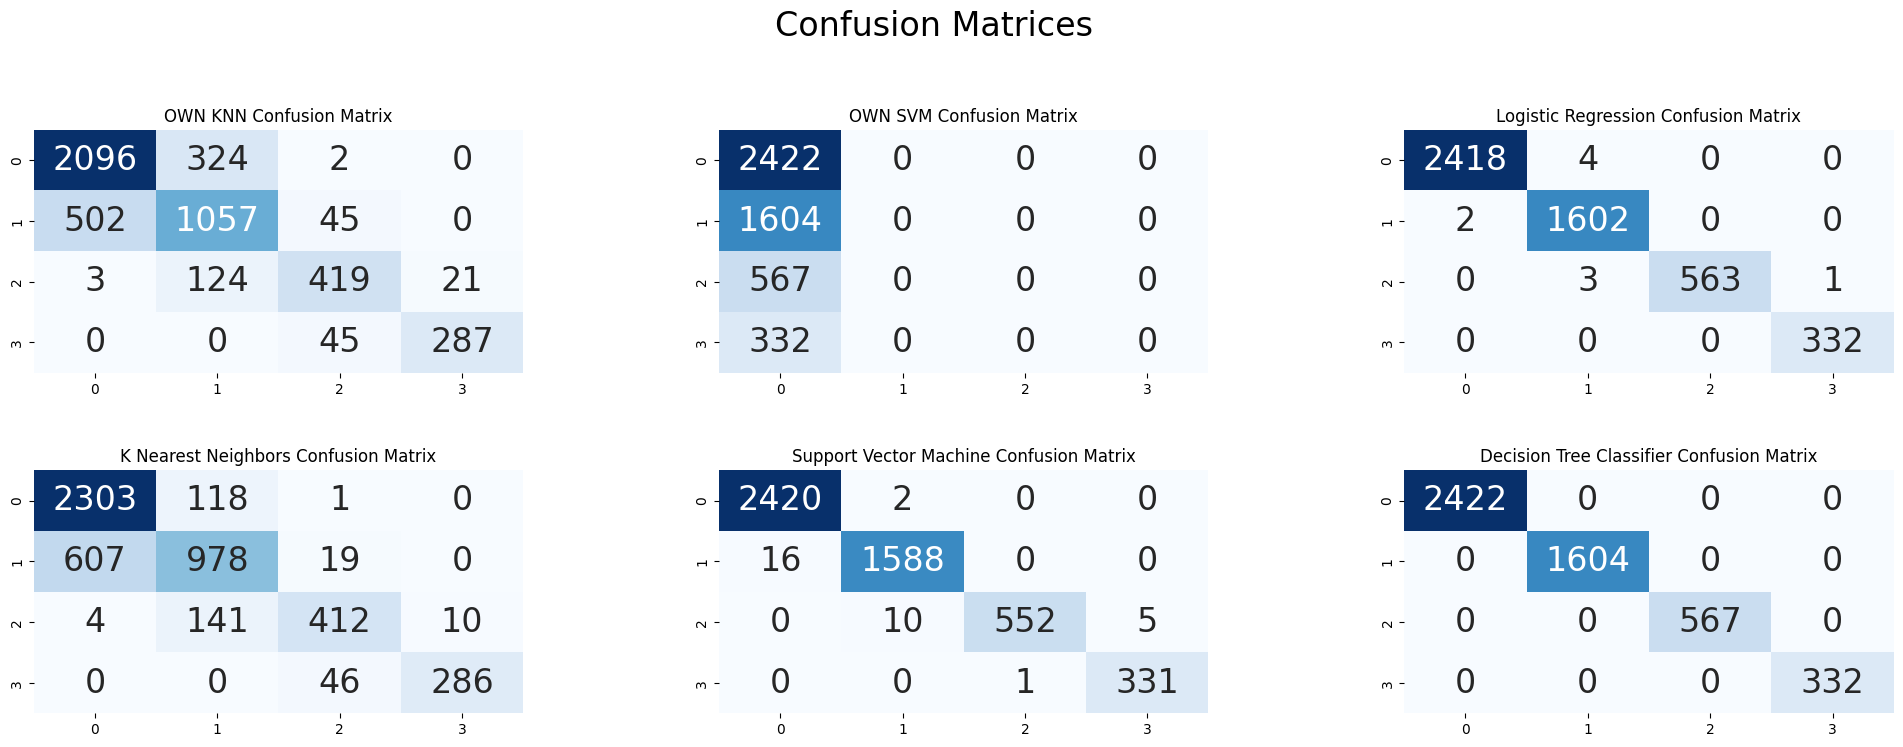

In [133]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)


plt.subplot(3,3,1)
plt.title("OWN KNN Confusion Matrix")
sns.heatmap(cm_own_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,2)
plt.title("OWN SVM Confusion Matrix")
sns.heatmap(cm_own_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})


plt.subplot(3,3,3)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,4)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,5)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,6)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

### Вывод: наиболее подходящими метриками для второго датасета являются библиотечные реализации дерева решений, логистической регрессии и метода опорных векторов. А библиотечная реализация К ближайших соседей практически совпадает с собственной реализации.